# Image Segmentation with U-Net
In this lab you will learn how to build and train an image segmentation model with `tf.keras` and (optionally) train at scale with Vertex AI.

Learning Objectives:
* Learn how to preprocess and augment data for image segmentation
* Learn how to build a U-net architecture with `tf.keras`
* Learn how to train this model with Vertex AI
* Learn how to serve and parse predictions 

## Setup

In [ ]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

In [1]:
import time
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

tf.keras.backend.clear_session()

PROJECT = !(gcloud config get-value project)
PROJECT = PROJECT[0]
REGION = "us-central1"
BUCKET = PROJECT
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
OUTPUT_DIR = f"gs://{BUCKET}/pets/models/{TIMESTAMP}"

# silence TF info logs
%env TF_CPP_MIN_LOG_LEVEL=3

print(tf.__version__)

env: TF_CPP_MIN_LOG_LEVEL=3
2.12.0


#### Visualize the data
The dataset used in this lab in the [Oxford Pet Dataset](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). It contains images of animals with segmentation masks. The goal of an image segmentation model is to take in as input an image and predict the segmentation mask. Think multi-classification problem, where each pixel is labelled as background, interior, or outline. 

In [2]:
def read_and_preprocess(data):
    input_image = tf.image.resize(data["image"], (128, 128))
    input_mask = tf.image.resize(data["segmentation_mask"], (128, 128))

    input_image = tf.image.convert_image_dtype(input_image, tf.float32)  # [0,1]
    input_mask -= 1  # {1,2,3} to {0,1,2}
    return input_image, input_mask

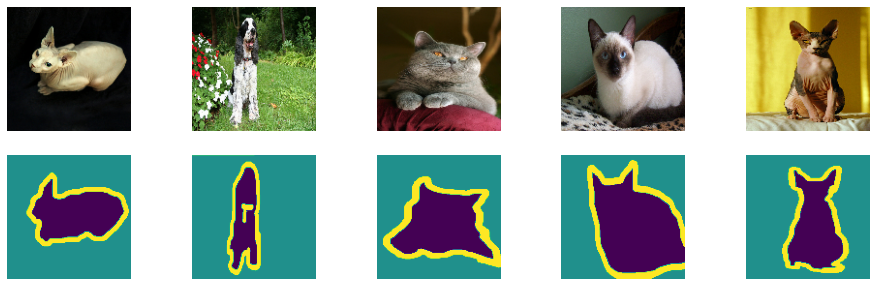

In [3]:
AUTO = tf.data.AUTOTUNE

# Load in the dataset with tfds
dataset, info = tfds.load(
    "oxford_iiit_pet",
    data_dir="gs://asl-public/data/tensorflow_datasets",
    with_info=True,
)

train = dataset["train"].map(read_and_preprocess, num_parallel_calls=AUTO)
test = dataset["test"].map(read_and_preprocess, num_parallel_calls=AUTO)

f, ax = plt.subplots(2, 5, figsize=(16, 5))
for idx, (img, mask) in enumerate(train.take(5)):
    ax[0, idx].imshow(tf.keras.preprocessing.image.array_to_img(img))
    ax[0, idx].axis("off")
    mask = tf.reshape(mask, [128, 128])
    ax[1, idx].imshow(mask.numpy())
    ax[1, idx].axis("off")

#### Data Augmentation
Create a function that randomly flips the image and mask left or right.

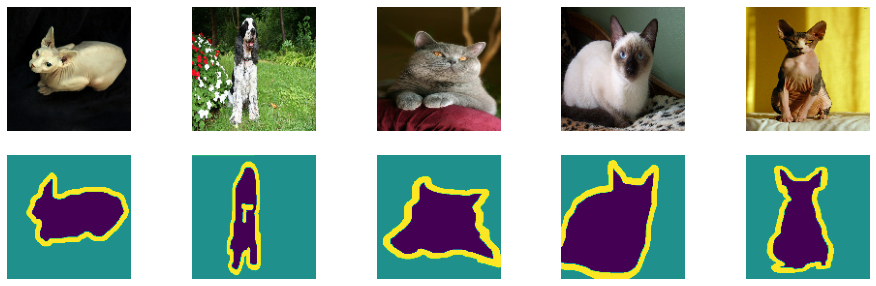

In [4]:
AUGMENT_PROB = 0.5  # probability of data augmentation


def augment(img, mask):
    if tf.random.uniform(()) < AUGMENT_PROB:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    return img, mask


train = train.map(augment)
test = test.map(augment)

f, ax = plt.subplots(2, 5, figsize=(16, 5))
for idx, (img, mask) in enumerate(train.take(5)):
    ax[0, idx].imshow(tf.keras.preprocessing.image.array_to_img(img))
    ax[0, idx].axis("off")
    mask = tf.reshape(mask, [128, 128])
    ax[1, idx].imshow(mask.numpy())
    ax[1, idx].axis("off")

### Modified U-Net

The model being used here is a modified [U-Net](https://arxiv.org/pdf/1505.04597v1.pdf). A U-Net typically consists of an encoder which downsamples an image to an encoding, and a mirrored decoder which upsamples the encoding back to the desired mask. The decoder blocks have a number of skip connections that directly connect the encoder blocks to the decoder.

In this notebook, we will use a pretrained MobileNetV2 to create the encoding and a set of upsampling layers (stride=2) to get back to the desired mask. When doing so, however, we will pull out layers with the desired sizes so that the upsampling skip layers use corresponding weights from the pretrained models. The layer names such as `block_1_expand_relu`, `block_3_expand_relu`, etc, correspond to these output layers of the pretrained MobileNetV2. If you would like to see the entire structure of the pretrained MobileNetV2, feel free to load it into memory and analyze it with `tf.keras.utils.plot_model` or `model.summary()`

Note that the output will consist of 3 channels. This is because we have 3 possible labels for each pixel (background, outline, interior). Think of this as multi-classification problem with three possible classes.

![image](https://storage.googleapis.com/asl-public/public-images/unet.png)
Architecture diagram from original research paper

In [5]:
# Specify shape and channels of input images
INPUT_SHAPE = [128, 128, 3]
OUTPUT_CHANNELS = 3

#### Create the Encoder (Downstack)

First, create an encoder which downsamples the input images. To keep things simple, use a pretrained model (MobileNetV2). Set `include_top=False` since you don't want to include the fully-connected layer at the top of the network. 

In [6]:
# load model into memory
base_model = tf.keras.applications.MobileNetV2(
    input_shape=INPUT_SHAPE, include_top=False
)

Recall that Unet uses outputs of the encoder to form skip connections to the decoder. Access these layers by name to create the output of the encoder, then instantiate it as a `tf.keras.Model`.

To make this architecture train faster you can freeze the weights of the encoder so they are not learned at training time. You can do this by setting the `trainable` attibute to `False` on the `tf.keras.Model`.

In [7]:
# Use the activations of these layers to form skip connections
layer_names = [
    "block_1_expand_relu",  # 64x64
    "block_3_expand_relu",  # 32x32
    "block_6_expand_relu",  # 16x16
    "block_13_expand_relu",  # 8x8
    "block_16_project",  # 4x4
]

# Outputs
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model_outputs,
    name="pretrained_mobilenet",
)

down_stack.trainable = False

print(f"Encoder Inputs:\n{down_stack.inputs}")
print("Encoder Outputs:")
for i in range(len(down_stack.outputs)):
    print(down_stack.outputs[i])

Encoder Inputs:
[<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_1')>]
Encoder Outputs:
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 96), dtype=tf.float32, name=None), name='block_1_expand_relu/Relu6:0', description="created by layer 'block_1_expand_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 144), dtype=tf.float32, name=None), name='block_3_expand_relu/Relu6:0', description="created by layer 'block_3_expand_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 192), dtype=tf.float32, name=None), name='block_6_expand_relu/Relu6:0', description="created by layer 'block_6_expand_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 576), dtype=tf.float32, name=None), name='block_13_expand_relu/Relu6:0', description="created by layer 'block_13_expand_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 320), dtype=tf.float32, name=None), name='block_16_project/Conv2D:0', description="created by layer 'block_16_

As you can see the encoder is expecting an image of height/width `[128, 128]` as input and is downsampling to `[64, 64]`, `[32, 32]`, `[16, 16]`, `[8, 8]`, and `[4, 4]`.

#### Create the Decoder (Upstack)

First, create a function that returns upsampling layers as simple `tf.keras.Sequential` models. Remember that the upsampling layers should double the image sizes. To do this we can use a [transposed convolutional layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) with `strides=2` and `padding="same"`. 

In [8]:
def upsample(filters, kernel_size, name, strides=2):
    return tf.keras.Sequential(
        [
            tf.keras.layers.Conv2DTranspose(
                filters, kernel_size, strides=strides, padding="same"
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
        ],
        name=name,
    )

Use the upsample function to create the upsampling layers that bring the dimensionality back up.

In [9]:
up_stack = [
    upsample(512, 3, "upsample_4x4_to_8x8"),
    upsample(256, 3, "upsample_8x8_to_16x16"),
    upsample(128, 3, "upsample_16x16_to_32x32"),
    upsample(64, 3, "upsample_32x32_to_64x64"),
]

up_stack

Send inputs through the encoder, create and establish the skip connections while upsampling through the decoder. 

In [10]:
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name="input_image")

# Downsampling through the model
skips = down_stack(inputs)
x = skips[-1]
skips = reversed(skips[:-1])

# Upsampling and establishing the skip connections
for idx, (up, skip) in enumerate(zip(up_stack, skips)):
    x = up(x)
    concat = tf.keras.layers.Concatenate(name=f"expand_{idx}")
    x = concat([x, skip])

The upstack as we have it now outputs with height/width `[64, 64]`. Create the last layer manually, which will be a `Conv2DTranspose` to upsample back to the original input shape. Then, instatiate the end-to-end architecture as a `tf.keras.Model`.

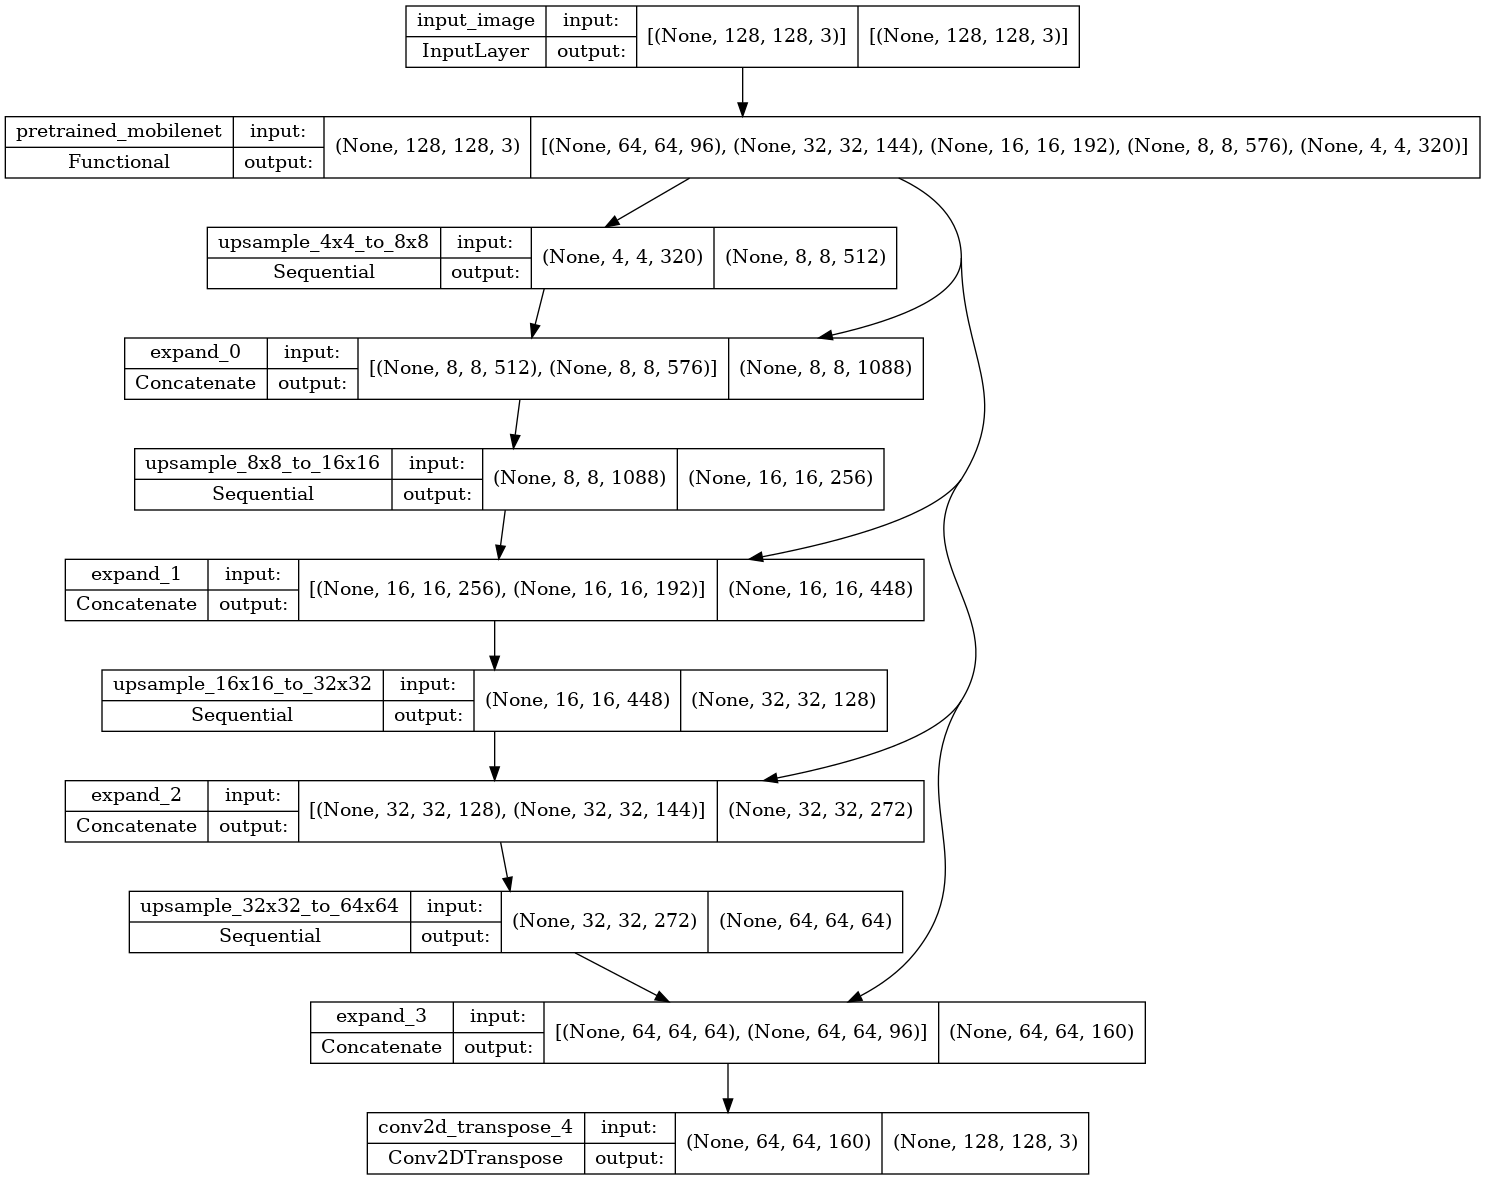

In [11]:
# This is the last layer of the model
last = tf.keras.layers.Conv2DTranspose(
    OUTPUT_CHANNELS, 3, strides=2, padding="same"
)  # 64x64 -> 128x128

x = last(x)
model = tf.keras.Model(inputs=inputs, outputs=x)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

tf.keras.utils.plot_model(model, show_shapes=True)

As you can see, the input is an image with shape `[128, 128, 3]`. This image gets downsampled using the pretrained MobileNetV2, then upsampled back to it's original size with `Conv2DTranspose`. Also, note the skip connections, critical to the Unet architecture. 

#### Train the model locally
**Note**: Without a GPU, training for 10 epochs can take ~ 45 minutes.

In [12]:
EPOCHS = 10
BATCH_SIZE = 8
STEPS_PER_EPOCH = info.splits["train"].num_examples // BATCH_SIZE
VALIDATION_STEPS = info.splits["test"].num_examples // BATCH_SIZE
MODEL_DIR = "./trained_unet"
train = train.batch(BATCH_SIZE).repeat()
test = test.batch(BATCH_SIZE)

In [13]:
history = model.fit(
    train,
    validation_data=test,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
)

Epoch 1/10
 71/460 [===>..........................] - ETA: 2:24 - loss: 0.8099 - accuracy: 0.6607

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 72/460 [===>..........................] - ETA: 2:24 - loss: 0.8099 - accuracy: 0.6604

Corrupt JPEG data: premature end of data segment


460/460 [==============================] - 247s 529ms/step - loss: 0.6630 - accuracy: 0.7197 - val_loss: 0.6955 - val_accuracy: 0.7117
Epoch 2/10
 71/460 [===>..........................] - ETA: 2:10 - loss: 0.6159 - accuracy: 0.7400

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 72/460 [===>..........................] - ETA: 2:10 - loss: 0.6175 - accuracy: 0.7391

Corrupt JPEG data: premature end of data segment


460/460 [==============================] - 237s 514ms/step - loss: 0.6008 - accuracy: 0.7466 - val_loss: 0.6583 - val_accuracy: 0.7275
Epoch 3/10
 71/460 [===>..........................] - ETA: 2:11 - loss: 0.5898 - accuracy: 0.7519

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 72/460 [===>..........................] - ETA: 2:11 - loss: 0.5912 - accuracy: 0.7512

Corrupt JPEG data: premature end of data segment


460/460 [==============================] - 238s 518ms/step - loss: 0.5796 - accuracy: 0.7568 - val_loss: 0.6768 - val_accuracy: 0.7199
Epoch 4/10
 71/460 [===>..........................] - ETA: 2:10 - loss: 0.5757 - accuracy: 0.7588

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 72/460 [===>..........................] - ETA: 2:10 - loss: 0.5771 - accuracy: 0.7581

Corrupt JPEG data: premature end of data segment


460/460 [==============================] - 236s 512ms/step - loss: 0.5677 - accuracy: 0.7627 - val_loss: 0.6244 - val_accuracy: 0.7374
Epoch 5/10
 70/460 [===>..........................] - ETA: 2:09 - loss: 0.5674 - accuracy: 0.7630

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 71/460 [===>..........................] - ETA: 2:09 - loss: 0.5666 - accuracy: 0.7633

Corrupt JPEG data: premature end of data segment


460/460 [==============================] - 235s 510ms/step - loss: 0.5556 - accuracy: 0.7679 - val_loss: 0.6031 - val_accuracy: 0.7480
Epoch 6/10
 70/460 [===>..........................] - ETA: 2:08 - loss: 0.5559 - accuracy: 0.7686

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 71/460 [===>..........................] - ETA: 2:08 - loss: 0.5556 - accuracy: 0.7687

Corrupt JPEG data: premature end of data segment


460/460 [==============================] - 234s 509ms/step - loss: 0.5488 - accuracy: 0.7710 - val_loss: 0.6004 - val_accuracy: 0.7505
Epoch 7/10
 70/460 [===>..........................] - ETA: 2:08 - loss: 0.5494 - accuracy: 0.7701

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 71/460 [===>..........................] - ETA: 2:08 - loss: 0.5490 - accuracy: 0.7703

Corrupt JPEG data: premature end of data segment


460/460 [==============================] - 233s 506ms/step - loss: 0.5417 - accuracy: 0.7741 - val_loss: 0.5965 - val_accuracy: 0.7516
Epoch 8/10
 70/460 [===>..........................] - ETA: 2:08 - loss: 0.5410 - accuracy: 0.7750

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 71/460 [===>..........................] - ETA: 2:08 - loss: 0.5406 - accuracy: 0.7752

Corrupt JPEG data: premature end of data segment


460/460 [==============================] - 232s 505ms/step - loss: 0.5341 - accuracy: 0.7772 - val_loss: 0.5977 - val_accuracy: 0.7488
Epoch 9/10
 70/460 [===>..........................] - ETA: 2:09 - loss: 0.5366 - accuracy: 0.7773

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 71/460 [===>..........................] - ETA: 2:08 - loss: 0.5357 - accuracy: 0.7778

Corrupt JPEG data: premature end of data segment


460/460 [==============================] - 232s 503ms/step - loss: 0.5296 - accuracy: 0.7793 - val_loss: 0.5859 - val_accuracy: 0.7574
Epoch 10/10
 71/460 [===>..........................] - ETA: 2:07 - loss: 0.5276 - accuracy: 0.7811

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 72/460 [===>..........................] - ETA: 2:06 - loss: 0.5294 - accuracy: 0.7803

Corrupt JPEG data: premature end of data segment


460/460 [==============================] - 233s 506ms/step - loss: 0.5224 - accuracy: 0.7824 - val_loss: 0.5806 - val_accuracy: 0.7610


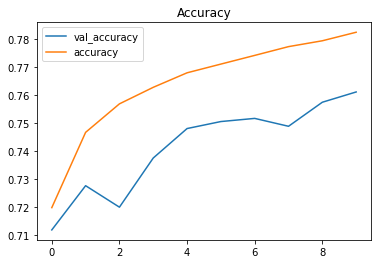

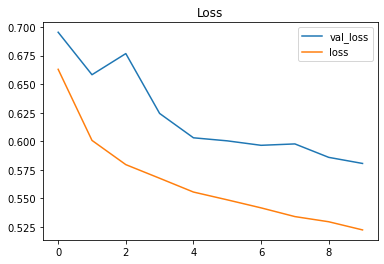

In [14]:
pd.DataFrame(history.history)[["val_accuracy", "accuracy"]].plot(
    title="Accuracy"
)
pd.DataFrame(history.history)[["val_loss", "loss"]].plot(title="Loss");

#### Visualize predictions
These are helper functions to visualize the predictions of the trained model. 

`create_mask`: Returns the mask assigning each pixel to the 'class' with the highest probabilty (background, outline, interior). 

`display`: Plots an input image, the true mask (label) of the image, and the predicted mask from our model.

`show_prediction`: Calls `display` for a specified number of input images.

In [15]:
def create_mask(pred_mask):
    """Given prediction mask, return highest probability per pixel"""
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def display(display_list):
    """Plot input image, true mask, and predicted mask"""
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


def show_predictions(dataset, num):
    """Display a certain number of predictions from a tf.data.Dataset"""
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

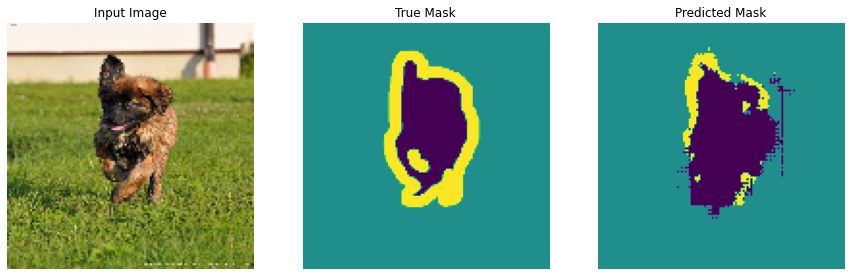

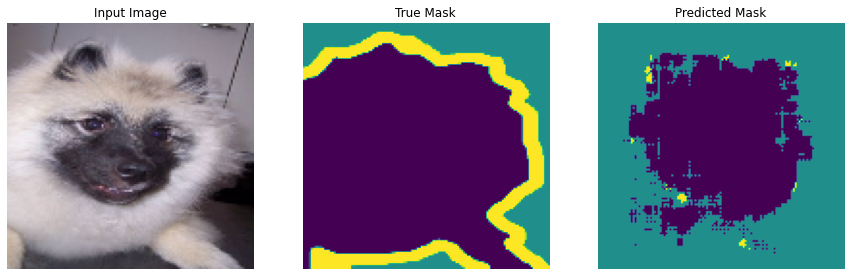

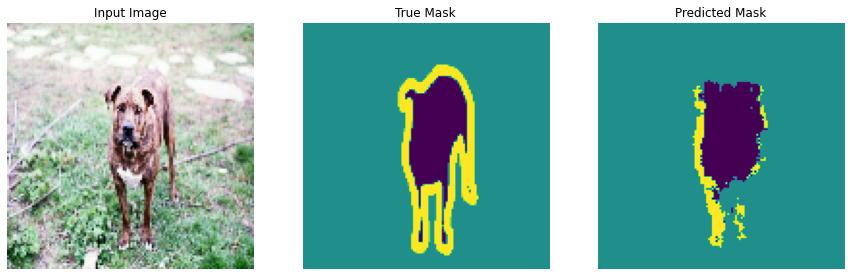

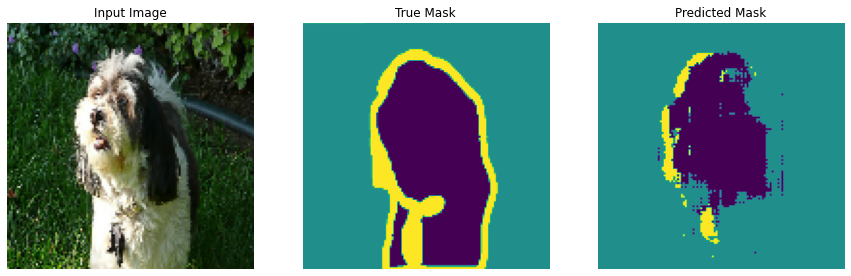

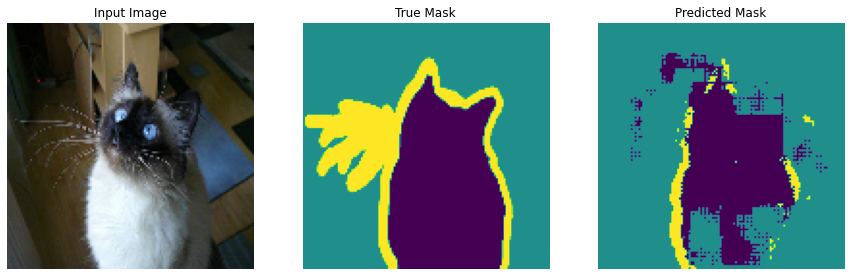

In [16]:
show_predictions(test, 5)

#### (Optional) Train on Vertex AI
In this section you containerize the training application and submit a custom training job to Vertex AI. The steps to do this are:

* Create Python script of the training application
* Create Dockerfile to bundle training script and deps
* Build and push Docker image
* Create and run Vertex AI Custom Training Job

In [17]:
!mkdir ./pets_trainer

In [18]:
%%writefile ./pets_trainer/train.py

import tensorflow as tf
import tensorflow_datasets as tfds
import fire

def read_and_preprocess(data):
    input_image = tf.image.resize(data['image'], (128,128))
    input_mask = tf.image.resize(data['segmentation_mask'], (128,128))
    
    input_image = tf.image.convert_image_dtype(input_image, tf.float32) # [0,1]
    input_mask -= 1 # {1,2,3} to {0,1,2}
    return input_image, input_mask
    
def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    return img, mask
    
def create_train_test_datasets(dataset, batch_size):
    train_ds = dataset['train'].map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = dataset['test'].map(read_and_preprocess)
    train_ds = train_ds.cache().map(augment).shuffle(10 * batch_size).batch(batch_size).repeat()
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    test_ds = test_ds.batch(batch_size)
    return train_ds, test_ds
    
def upsample(filters, size, name):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()], name=name)

def build_unet(input_shape, output_channels):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False)
    
    # Use the activations of these layers to form skip connections
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
    
    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs,
                                name='pretrained_mobilenet')

    down_stack.trainable = False
    
    up_stack = [
        upsample(512, 3, 'upsample_4x4_to_8x8'),
        upsample(256, 3, 'upsample_8x8_to_16x16'),
        upsample(128, 3, 'upsample_16x16_to_32x32'),
        upsample(64, 3,  'upsample_32x32_to_64x64')
    ]
    
    inputs = tf.keras.layers.Input(shape=input_shape, name='input_image')
    
    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for idx, (up, skip) in enumerate(zip(up_stack, skips)):
        x = up(x)
        concat = tf.keras.layers.Concatenate(name='expand_{}'.format(idx))
        x = concat([x, skip])
        
    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128
    
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)
    
    
def train_evaluate(
    batch_size=64,
    tf_dataset='oxford_iiit_pet',
    data_dir='gs://asl-public/data/tensorflow_datasets',
    input_shape=[128,128,3],
    output_channels=3,
    epochs=10,
    output_dir=None
):
    
    # Download dataset from tfds
    dataset, info = tfds.load(tf_dataset, data_dir=data_dir, with_info=True)
    
    # Create train and test datasets
    train_ds, test_ds = create_train_test_datasets(dataset, batch_size)
    
    steps_per_epoch = info.splits['train'].num_examples // batch_size
    validation_steps = info.splits['test'].num_examples // batch_size
    
    model = build_unet(input_shape, output_channels)
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    
    history = model.fit(
        train_ds, 
        validation_data=test_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
    
    if output_dir:
        model.save(output_dir)
        
if __name__ == '__main__':
    fire.Fire(train_evaluate)

Writing ./pets_trainer/train.py


#### Write Dockerfile

In [19]:
%%writefile ./pets_trainer/Dockerfile
FROM us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-12.py310:latest

# Installs fire
RUN pip install -U fire tensorflow_datasets

# Copies the trainer code to the docker image.
WORKDIR /app
COPY train.py .

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "train.py"]

Writing ./pets_trainer/Dockerfile


#### Build and push containerized training application

In [20]:
ARTIFACT_REGISTRY_DIR = "asl-artifact-repo"
IMAGE_NAME = "pets_trainer_tf"
TAG = "latest"
TRAINING_CONTAINER_IMAGE_URI = (
    f"us-docker.pkg.dev/{PROJECT}/{ARTIFACT_REGISTRY_DIR}/{IMAGE_NAME}:{TAG}"
)
TRAINING_CONTAINER_IMAGE_URI

'us-docker.pkg.dev/takumiohym-sandbox/asl-artifact-repo/pets_trainer_tf:latest'

In [21]:
!gcloud builds submit --machine-type=e2-highcpu-32 --timeout=15m --tag $TRAINING_CONTAINER_IMAGE_URI pets_trainer

Creating temporary tarball archive of 2 file(s) totalling 4.3 KiB before compression.
Uploading tarball of [pets_trainer] to [gs://takumiohym-sandbox_cloudbuild/source/1711034082.794887-a1eb04bee48443308b78c4b5d8e67531.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/takumiohym-sandbox/locations/global/builds/baa7458e-c575-49a4-90c2-2a58adf435b0].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/baa7458e-c575-49a4-90c2-2a58adf435b0?project=237937020997 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "baa7458e-c575-49a4-90c2-2a58adf435b0"

FETCHSOURCE
Fetching storage object: gs://takumiohym-sandbox_cloudbuild/source/1711034082.794887-a1eb04bee48443308b78c4b5d8e67531.tgz#1711034083048481
Copying gs://takumiohym-sandbox_cloudbuild/source/1711034082.794887-a1eb04bee48443308b78c4b5d8e67531.tgz#1711034083048481...
/ [1 files][  1.9 KiB/  1.9 KiB]                                                
Operation

#### Run Custom Training Job on Vertex AI 

Check to make sure bucket exists and if not create it

In [28]:
STAGING_BUCKET = f"gs://{BUCKET}-staging"

%env STAGING_BUCKET={STAGING_BUCKET}
%env REGION={REGION}

env: STAGING_BUCKET=gs://kylesteckler-instructor-staging
env: REGION=us-central1


In [30]:
%%bash
exists=$(gsutil ls -d | grep -w ${STAGING_BUCKET}/)

if [ -n "$exists" ]; then
   echo -e "Bucket gs://${BUCKET} already exists."
    
else
   echo "Creating a new GCS bucket."
   gsutil mb -l ${REGION} ${STAGING_BUCKET}
   echo -e "\nHere are your current buckets:"
   gsutil ls
fi

Creating a new GCS bucket.

Here are your current buckets:
gs://artifacts.kylesteckler-instructor.appspot.com/
gs://asl-public/
gs://cloud-ai-platform-f0eeec23-3a71-4a0d-a65e-72ecd31f17de/
gs://kyles-public-bucket/
gs://kylesteckler-instructor/
gs://kylesteckler-instructor-flowers/
gs://kylesteckler-instructor-flowers-kfp-artifact-store/
gs://kylesteckler-instructor-staging/
gs://kylesteckler-instructor.appspot.com/
gs://kylesteckler-instructor_cloudbuild/
gs://staging.kylesteckler-instructor.appspot.com/


Creating gs://kylesteckler-instructor-staging/...


In [31]:
# Specify variables used to configure hyperparameter tuning job
DISPLAY_NAME = "pets-segmentation"
JOB_NAME = f"unet-custom-training-{TIMESTAMP}"
EPOCHS = 50

In [34]:
from google.cloud import aiplatform

# Define required specifications
worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": "n1-standard-8",
            "accelerator_type": "NVIDIA_TESLA_T4",
            "accelerator_count": 1,
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": TRAINING_CONTAINER_IMAGE_URI,
            "args": [f"--output_dir={OUTPUT_DIR}", f"--epochs={EPOCHS}"],
        },
    }
]

custom_job = aiplatform.CustomJob(
    display_name=JOB_NAME,
    project=PROJECT,
    worker_pool_specs=worker_pool_specs,
    staging_bucket=STAGING_BUCKET,
)

In [ ]:
custom_job.run()

Congrats! You've succesfully trained a custom U-net model for image segmentation and operationalized model training with Vertex AI.